<a href="https://colab.research.google.com/github/DurdenTyler2008/University-of-AI/blob/main/%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%20%D0%A2%D0%B5%D0%BA%D1%81%D1%82%D0%B0%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Написать сети для сегментациии договоров при помощи: 

1.   Linear Conv1D
2.   PSPnet
3.   UNET




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# устанавливаю лемматизатор (Лемматизация — процесс приведения словоформы к лемме — её нормальной (словарной) форме.)

In [4]:
!pip install -q pymorphy2       # лемматизатор pymorphy2

In [5]:
!pip install tensorflow==2.3     # устанавливаю версию tf 2.3 и делаем restart runtime

In [6]:
import numpy as np 
from tensorflow.keras.models import Model, load_model
import re                                                   # Имортируем чтобы работать с строками
from tensorflow.keras.preprocessing.text import Tokenizer   # Метод, который поволяет работать с текстами и конвертирует их в последовательности (индексов)
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K                   # Импортируем, чтобы высчитать dice_coef(ошибку)
from tensorflow.keras.optimizers import Adam, Adadelta 
from tensorflow.keras import utils                          # Импортируем для работы с категориальными данными
import tensorflow
from google.colab import files 
import matplotlib.pyplot as plt 
from gensim.models import word2vec                          # Импортируем gensim
import os 
import pandas as pd
import time 
import nltk                                                 # Natural language toolkit - Инструментарий естественного языка
from nltk.stem import WordNetLemmatizer                     # Импортируем для работы с леммами
import pymorphy2                                            # Импортируем для работы с леммами

nltk.download('wordnet')                                    # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

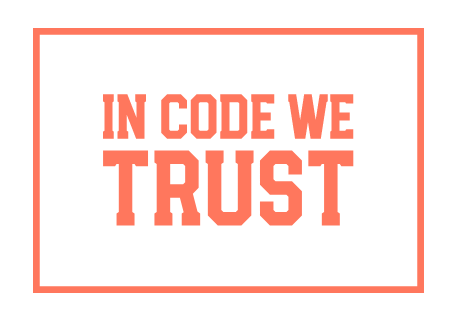

In [7]:
from IPython.display import Image
Image("/content/drive/MyDrive/Logo/logo9.png", width=150, height=100)

In [8]:
!unzip '//content/drive/MyDrive/Базы/Договора432-20210809T081459Z-001.zip' -d '//content/drive/MyDrive/Базы/Договоры 432/'

Archive:  //content/drive/MyDrive/Базы/Договора432-20210809T081459Z-001.zip
replace //content/drive/MyDrive/Базы/Договоры 432/Договора432/Трудовой контракт с руководителем предприятия о предпринимательской деятельности.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Создаю функции для работы с текстами:



In [ ]:
"""
<s1> - Условия
<s2> - Запреты
<s3> - Цена
<s4> - Условия (относительно дат)
<s5> - Штрафы
<s6> - Адреса и местоположения

Превращаю договоры в листы слов
"""

In [9]:
def readText(fileName):                     # Функция  удаляющая пунктуационные знаки препинания и дополнительные ненужные знаки

    f = open(fileName, 'r')                 # Открываю файл и считываю наши данные
    text = f.read()                         # Кладу текст в переменную
    
    delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%'] # Какие знаки будут удалены

    for dS in delSymbols:                   
        text = text.replace(dS, " ")        # Удаляю знак, посредством замены этого знака на пробел
    # Выискиваю дополнительные знаки в текстах посредством паттернов и определяю на что их заменять
    text = re.sub("[.]", " ", text)
    text = re.sub(":", " ", text)
    text = re.sub("<", " <", text)
    text = re.sub(">", "> ", text)

    # split  метод разделит текст на последовательность слов при помощи пробелов
    # Используя join метод, мы обратно соберём последовательности слов в текст

    text = ' '.join(text.split()) 
    text = text.lower()               # Привожу текст к нижнему регистру

    return text 

def text2Words(text):     # Функция конвертирующая исходный текст в лист слов с начальной формой

    morph = pymorphy2.MorphAnalyzer()                             # Инструмент для работы с морфемами и более
    words = text.split(' ')                                       # Разделяю текст по средством пробелов
    docs = [morph.parse(word)[0].normal_form for word in words]   # Преобразую каждое слово в элемент списка

    return docs 

# Считываю разархивированную базу:



In [10]:
directory = '/content/drive/MyDrive/Базы/Договоры 432/Договора432/' 
os.listdir(directory)[50:60]          # название 10 договоров с 50 по 60й

['Договор страхования ответственности застрахованного за причинение вреда имуществу других лиц.txt',
 'Договор страхования ответственности страхователя за причинение вреда.txt',
 'Договор страхования ответственности застрахованного за причинение вреда в результате эксплуатации автотранспортного средства.txt',
 'Договор страхования ответственности застрахованного за причинение вреда.txt',
 'Договор смешанного страхования жизни (объект страхования - жизнь страхователя_ в пользу страхователя).txt',
 'Договор страхования ответственности застрахованного за причинение вреда жизни и здоровью других лиц.txt',
 'ДОГОВОР УСТУПКИ ПРАВА ТРЕБОВАНИЯ ПО ПОДРЯДНЫМ РАБОТАМ.txt',
 'ДОГОВОР ФИНАНСИРОВАНИЯ ПОД УСТУПКУ ДЕНЕЖНОГО ТРЕБОВАНИЯ (ФАКТОРИНГ).txt',
 'Договор участия в долевом строительстве жилого дома.txt',
 'Договор страхования имущества (страхователь - юридическое лицо, в пользу выгодоприобретателя - юридического лица).txt']

In [11]:
print('Всего в базе:', len(os.listdir(directory)), 'договора')

Всего в базе: 428 договора


In [12]:
curTime = time.time()                     # Засекаю текущее время
agreements = []                           # писок, что будет хранить все договоры

for filename in os.listdir(directory): 
    txt = readText(directory + filename)  # Считываю текст в договоре
    if txt != '':                         # Если договор не пустой
        agreements.append(readText(directory + filename))       # Преобразую файл в текст и добавляем его в agreements
print('Загрузка файла заняла: ', round(time.time() - curTime, 2), 'sec')

Загрузка файла заняла:  1.15 sec


In [13]:
n = 3
print(os.listdir(directory)[n]) 
agreements[n]                   # Текст n-ого договора

Трудовой договор с сотрудником акционерного общества.txt


'трудовой договор с сотрудником акционерного общества г г настоящий контракт заключен между в лице директора генерального директора именуемым в дальнейшем работодатель с одной стороны и гражданином кой россии именуемым в дальнейшем работник настоящий контракт регулирует трудовые и иные отношения между работником и работодателем договаривающиеся стороны признают что их права и обязанности регулируются настоящим контрактом а также действующими коллективными соглашениями договорами правилами трудового распорядка общества и нормами действующего законодательства россии <s1> работник и работодатель договорились что будут добросовестно выполнять условия контракта и уважать взаимную свободу личной общественной и политической жизни а также свободу участия в ассоциациях и общественных организациях </s1> <s1> права установленные данным контрактом соблюдаются без какой либо дискриминации работника независимо от его политических взглядов религиозной принадлежности социального происхождения имуществ

In [14]:
n = 30
print(os.listdir(directory)[n]) 
agreements[n] 

Соглашение о намерениях.txt


'соглашение о намерениях г г в лице действующего на основании именуемый в дальнейшем сторона 1 с одной стороны и в лице действующего на основании именуемый в дальнейшем сторона 2 с другой стороны именуемые в дальнейшем стороны согласовали следующие намерения стороны исходят из того что интересам каждой из них соответствует реализация и они намереваются содействовать его осуществлению <s1> в этих целях каждая их сторон будет собирать необходимую информацию разрабатывать проекты документов и т п </s1> <s4> для принятия окончательного решения о возможности реализации вышеназванного проекта уполномоченные представители сторон встречаются не позднее года </s4> настоящее соглашение является предварительным и не налагает на его участников никаких финансовых и юридических обязательств'

In [15]:
docs_full = []                                      # Список будет содержать все договоры как списки документов
curTime = time.time()               

for i in range(len(agreements)): 
    docs_full.append(text2Words(agreements[i]))     # Преобразую договор в список слов и добавляю его в docs_full
print('Превращение заняло: ', round((time.time() - curTime) / 60, 2), 'min')

Превращение заняло:  2.73 min


In [16]:
print('Число записей в наборе данных:', len(docs_full)) 

# Выбираю итоговое количество данных для обучающей/проверочной и тестовой выборках

docs = docs_full[0:-10]
docsToTest = docs_full[-10:]

Число записей в наборе данных: 418


In [17]:
print('Число текстов в для тестовой проверки:', len(docsToTest)) 
print('Число договоров для обучающей и проверочной выборках:',len(docs)) 
print('Число слов в первом договоре:', len(docs[10]))

Число текстов в для тестовой проверки: 10
Число договоров для обучающей и проверочной выборках: 408
Число слов в первом договоре: 2784


In [18]:
print('Пример текста обычного:')
print(agreements[4][:62], '\n')
print('Тот же текст, но представленный ввиде лемм(нормальной (словарной) формы):')
print(docs[4][:10])

Пример текста обычного:
трудовой контракт с директором коммерческого банка г г в лице  

Тот же текст, но представленный ввиде лемм(нормальной (словарной) формы):
['трудовой', 'контракт', 'с', 'директор', 'коммерческий', 'банк', 'г', 'г', 'в', 'лицо']


In [19]:
print('Пример текста обычного:')
print(agreements[10][:100], '\n')
print('Тот же текст, но представленный ввиде лемм(нормальной (словарной) формы):')
print(docs[10][:10])

Пример текста обычного:
трудовой контракт с главным бухгалтером г г в лице действующего на основании именуемый в дальнейшем  

Тот же текст, но представленный ввиде лемм(нормальной (словарной) формы):
['трудовой', 'контракт', 'с', 'главный', 'бухгалтер', 'г', 'г', 'в', 'лицо', 'действовать']


# Преобразование текстов в последовтельность индексов: создание xTrain


In [20]:
 tokenizer = Tokenizer(lower=True, filters = '', char_level=False)
# lower=True - приводит к нижнему регистру все слова
# char_level=False - говорит токенайзеру не инициализировать отдельно каждую букву как токен 

tokenizer.fit_on_texts(docs_full)             # Скармливаю тексты токенайзеру
clean_voc = {}                                # Пустой словарь

for item in tokenizer.word_index.items():     # Преобразую лист в словарь
    clean_voc[item[0]] = item[1]              # Мы меняем местами элеметны кортежа

In [21]:
print('Словарь всех слов по их частотноти:') 
print(clean_voc, '\n')
print('Длина словаря:', len(clean_voc))

Словарь всех слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'работа': 24, 'право': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'имущество': 35, 'арендатор': 36, 'действовать': 37, 'день': 38, 'лицо': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'дальнейший': 45, 'п': 46, 'работник': 47, 'который': 48, 'обязательство': 49, 'а': 50, 'законодательство': 51, 'порядок': 52, 'арендодатель': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'свой': 57, 'счёт': 58, 'соответствие': 59, 'указанный': 60, 'страховой': 61, 'именовать': 62, 'из': 63, 'мочь': 64, 'основание': 65, 'исполнение': 66, 'один': 67, 'обязанность': 68, 'обязать': 69, 'иной': 70, 'год': 71, 'трудовой': 72, 'г': 73, 'до': 74, 'заказчик

In [22]:
tag = '<s1>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s2>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s3>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s4>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s5>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

tag = '<s6>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Индекс тега <s1> : 12
Индекс тега <s2> : 352
Индекс тега <s3> : 22
Индекс тега <s4> : 27
Индекс тега <s5> : 117
Индекс тега <s6> : 276


###Преобразую текст в последовательность индексов согласно словарю частотности:

In [23]:

tok_agreem = tokenizer.texts_to_sequences(docs)     # Обучающий выборка в последовтельность индексов

print("Фрагмент обучающей выборки:")
print("Исходный текст:\n", docs[4][:20])
print("Тот же текст, как последовательность индексов:\n", tok_agreem[4][:20])

Фрагмент обучающей выборки:
Исходный текст:
 ['трудовой', 'контракт', 'с', 'директор', 'коммерческий', 'банк', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона']
Тот же текст, как последовательность индексов:
 [72, 184, 8, 214, 348, 104, 73, 73, 1, 39, 37, 10, 65, 62, 1, 45, 128, 8, 67, 7]


# Создание yTrain:

Каждый индекс (слово) из договора будет соответсвовать вектору, чьи элементы соотвествуют категориям тегов

In [24]:
def getXYSamples(tok_agreem, tags_index):

    tags01 = []                                   # список тегов
    indices = []                                  # список индексов
  
    for agreement in tok_agreem:
      tag_place = [0, 0, 0, 0, 0, 0]              # создаю вектор [0,0,0,0,0,0] по числу типов разбивки базы s1-s6
      for ex in agreement:
          if ex in tags_index:                    # если индекс слова соотвествует индексу одного из тегов
              place = np.argwhere(tags_index==ex) # запоминаю позицию тега в этом листе тегов
              if len(place)!=0:                   # если тег в самом деле есть
                  if place[0][0]<6:               # первые 6 тегов - открывающие теги
                      tag_place[place[0][0]] = 1  # устанавливаю значение 1
                  else: 
                      tag_place[place[0][0] - 6] = 0  # все остальные теги закрывающие, так что мы меняем в соответсвующем месте в векторе на 0
          else:          
              tags01.append(tag_place.copy())     # добавляю в список тегов новые вектора мульти-лейбл классификации. 
                                                  # в итоге будет большой список всех вектор-тегов
              indices.append(ex)                  # добавляю индекс-слова в лист индексов

    return indices, tags01


def reverseIndex(clean_voc, x):                   # функция получения списка слов из листа индексов

    reverse_word_map = dict(map(reversed, clean_voc.items()))   # ключ и значение из словаря и меняю местами
    docs = [reverse_word_map.get(letter) for letter in x]       # кладу их в список

    return docs # Возвращает текст

In [25]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)]   # список открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)]   # список закрывающих тегов
tags_index.extend(closetags)                              # конкатенируем(объединяем) все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # получаю инексы всех тегов из словря частотности
print('Индексы всех тегов:', tags_index)

Индексы всех тегов: [ 12 352  22  27 117 276  13 357  23  28 118 268]


In [27]:
curTime = time.time()

xData, yData = getXYSamples(tok_agreem,tags_index)  # получаю теги и создаю списки с ними
decoded_text = reverseIndex(clean_voc, xData)       # чтобы создать список для эмбеддинга, преобразую список индексов обратно в список слов
print('Преобразование заняло: ', round(time.time() - curTime, 2), 'sec')

Преобразование заняло:  2.86 sec


In [28]:
print('длина xData:', len(xData))
print('длина yData:', len(yData))

print('Исходные слова:\n', docs[0][50:80])
print('Сдекодированые слова:\n', decoded_text[50:80])
print('Часть xData:\n', xData[50:80])
print('Часть yData:\n', yData[50:80])

длина xData: 403622
длина yData: 403622
Исходные слова:
 ['1', 'предмет', 'договор', '1', '1', 'гр', 'назначаться', 'на', 'должность', 'руководитель', 'предприятие', 'с', 'возложение', 'на', 'он', 'предпринимательский', 'полномочие', 'предусмотреть', 'законодательство', 'устав', 'предприятие', 'и', 'настоящий', 'контракт', '2', 'срок', 'контракт', '2', '1', '<s4>']
Сдекодированые слова:
 ['1', 'предмет', 'договор', '1', '1', 'гр', 'назначаться', 'на', 'должность', 'руководитель', 'предприятие', 'с', 'возложение', 'на', 'он', 'предпринимательский', 'полномочие', 'предусмотреть', 'законодательство', 'устав', 'предприятие', 'и', 'настоящий', 'контракт', '2', 'срок', 'контракт', '2', '1', 'контракт']
Часть xData:
 [5, 112, 2, 5, 5, 518, 1509, 10, 490, 658, 223, 8, 2342, 10, 18, 1241, 830, 97, 51, 608, 223, 3, 9, 184, 4, 26, 184, 4, 5, 184]
Часть yData:
 [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0

##  Разделение выборки на фрагменты(окна):



In [29]:
def getSetFromIndices(wordIndices, xLen, step):  # функция создания выборки из индексов

    xBatch = []                                  # список, хранящий фрагменты текста
    wordsLen = len(wordIndices)                  # получаем длину текста
    index = 0                                    # стартовый индекс
    
    while (index + xLen <= wordsLen):                 # пока сумма индекса и окна меньше или равно чем число слов в выборке
        xBatch.append(wordIndices[index:index+xLen])  # добавляю X в лист, что содержит наши фрагменты(окна) текста
        index += step                                 # смещаю индекс на наш шаг(step)

    return xBatch                                     # список фрагментов текста

In [30]:
xLen = 256              # Длина каждого окна
step = 30               # шаг 
embeddingSize = 300     # Число измерений вектор-пространства для каждого нашего слова 

### Генерирую выборки с параметрами фрагментов(окон):

In [31]:
xTrain = getSetFromIndices(decoded_text, xLen, step)    # Последовательность индексов с окном xLen слов
yTrain = getSetFromIndices(yData, xLen, step)           # Последовательность индексов с окном xLen от тегов

In [32]:
print('Длина xTrain:', len(xTrain))
print('Длина yTrain:', len(yTrain))
print('Длина примера из xTrain:',len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain\n', xTrain[0])
print('Пример yTrain\n', yTrain[0], '\n')

print('Первый пример xTrain:\n', xTrain[0][step-5:step+5])
print('Второй пример xTrain:\n', xTrain[1][:10])
print('Десятый пример xTrain:\n', xTrain[9][:10])

Длина xTrain: 13446
Длина yTrain: 13446
Длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain
 ['трудовой', 'контракт', 'с', 'руководитель', 'предприятие', 'о', 'предпринимательский', 'деятельность', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'собственник', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'предприниматель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'гр', 'назначаться', 'на', 'должность', 'руководитель', 'предприятие', 'с', 'возложение', 'на', 'он', 'предпринимательский', 'полномочие', 'предусмотреть', 'законодательство', 'устав', 'предприятие', 'и', 'настоящий', 'контракт', '2', 'срок', 'контракт', '2', '1', 'контракт', 'заключаться', 'между', 'собственник', 'и', 

In [33]:
# Преобразую текст в последовательность индексов согласно словарю частотности

tok_agreemTest = tokenizer.texts_to_sequences(docsToTest)       # обучающий текст в индексы

print("Фрагмент тестового текста:")
print("Исходный текст:\n", docsToTest[4][:20])
print("Тот же текст, как последовательность индексов:\n", tok_agreemTest[4][:20], '\n')

xDataTest, yDataTest = getXYSamples(tok_agreemTest,tags_index)  # распознаю теги и создаю список, что их хранят
decoded_text = reverseIndex(clean_voc, xDataTest)               # чтобы создать лист для эмбеддинга, нам нужно превратить лист индексов обратно в лист слов
print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))

print('Сдекодированные текст:\n', decoded_text[50:80])
print('Часть xDataTest:     ', xDataTest[50:80])
print('Часть yDataTest:     ', yDataTest[50:80])

xLen = 256                # Длина окна
step = 30                 # Шаг 
embeddingSize = 300       # Число измерений вектор-пространства для каждого нашего слова 

# Генерирую выборки с определёнными параметрами

xTest = getSetFromIndices(decoded_text, xLen, step)   # последовательность индексов с окном Xlen слов
yTest = getSetFromIndices(yDataTest, xLen, step)      # последовательность индексов с окном Xlen от тегов

print('Длина xTest:', len(xTest))
print('Длина yTest:', len(yTest))
print('Длина примера xTest:',len(xTest[0]))
print('Длина примера yTrain:',len(yTest[0]), '\n')
print('Пример xTest', xTest[0])
print('Пример yTest', yTest[0], '\n')

print('Первый пример xTest:', xTest[0][step-5:step+5])
print('Второй пример xTest:', xTest[1][:10])
print('Десятый пример xTest:', xTest[9][:10])

Фрагмент тестового текста:
Исходный текст:
 ['договор', 'пожизненный', 'содержание', 'с', 'иждивение', 'с', 'предоставление', 'иной', 'жилой', 'помещение', 'для', 'проживание', 'взамен', 'передаваемый', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер']
Тот же текст, как последовательность индексов:
 [2, 1285, 455, 8, 2484, 8, 368, 70, 319, 81, 41, 1082, 4068, 384, 73, 73, 264, 249, 270, 228] 

Длина xDataTest: 9204
Длина yDataTest: 9204
Сдекодированные текст:
 ['дальнейший', 'договор', 'о', 'нижеследующий', '1', 'общий', 'положение', '1', '1', 'банк', 'обязываться', 'принимать', 'от', 'вкладчик', 'денежный', 'сумма', 'вклад', 'и', 'возвратить', 'сумма', 'вклад', 'и', 'выплатить', 'процент', 'на', 'она', 'в', 'порядок', 'предусмотреть', 'договор']
Часть xDataTest:      [45, 2, 20, 205, 5, 140, 207, 5, 5, 104, 113, 231, 29, 596, 172, 54, 299, 3, 537, 54, 299, 3, 438, 285, 10, 181, 1, 52, 97, 2]
Часть yDataTest:      [[0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0], [0, 0, 0,

###Функция, что считает ошибку (нужна для точности):


In [34]:
def dice_coef(y_true, y_pred):
  
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

###Создаю функцию, возвращающую линейную свёрточную сеть Conv1D:


In [35]:
def create_Conv1d(xLen, embeddingSize): 

    text_input_layer = Input((xLen,embeddingSize)) 
    text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_input_layer)
    text_layer = Conv1D(16, 3, padding='same',activation='relu')(text_layer)
    text_layer = Conv1D(16, 3,padding='same', activation='relu')(text_layer) 
    text_layer = Conv1D(GENSIMtrainY.shape[-1], 3, padding='same',activation='sigmoid')(text_layer)

    model = Model(text_input_layer, text_layer)
    model.compile(optimizer=Adadelta(),loss='categorical_crossentropy', metrics=[dice_coef])

    return model

### Создаю функцию, возвращающую сеть PSP:


In [36]:
def create_PSPNet(conv_size = 64, num_classes = 6, input_shape = (30, 300)):
    img_input = Input(input_shape)

    # Блок 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(conv_size, 2, strides=2)(x_mp_2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(conv_size, 4, strides=4)(x_mp_4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(conv_size, 8, strides=8)(x_mp_8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(conv_size, 16, strides=16)(x_mp_16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(conv_size, 32, strides=32)(x_mp_32)
    x_mp_32 = Activation('relu')(x_mp_32)

    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(lr=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

###Создаю функцию, возвращающую сеть UNET:


In [37]:
def create_unet(k = 1, num_classes = 6, input_shape= (30, 300)):
    img_input = Input(input_shape) 

    # Блок 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(64 * k, 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation('relu')(x) 

    # Блок 2
    x = MaxPooling1D()(block_1_out)
    x = Conv1D(128 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation('relu')(x)

    # Блок 3
    x = MaxPooling1D()(block_2_out)
    x = Conv1D(256 * k, 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation('relu')(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation('relu')(x)

    # Блок 4
    x = MaxPooling1D()(block_3_out)
    x = Conv1D(512 * k, 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation('relu')(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(256 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation('relu')(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP 3
    x = Conv1DTranspose(128 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv1DTranspose(64 * k, kernel_size=3, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), loss='categorical_crossentropy', metrics=[dice_coef])
  
    return model

###Создаю xTrain и  yTrain используя Word2Vec библиотеки GENSIM:



In [38]:
def pad_zeros(phrase, xLen = 256):          # Функция для дополнением нулями

    while len(phrase) < xLen:               # пока сущестующий размер меньше чем требуемый 
      phrase.append([0] * embeddingSize)    # продолжаю добавлять элементы(нули) в фразу(zero-pad)  
    if len(phrase) > xLen:                  # иначе случае, если фраза больше чем  требуемый размер
      phrase = phrase[:xLen]                # беру только требуемое число элементов

    return phrase                           # возвращаю обработанную фразу


def getSets(model, senI, tagI):             # функция выборки

    xVector = []                            # список будет содержать ембеддинг представление на каждый индекс
    tmp = []                                # временный список
    for text in senI: 
      tmp=[]
      for word in text: 
        try:                                # если слово есть в модели (словарь не слишком мал), мы не получим ошибку
            tmp.append(model[word])
        except:                             # иначе случае пропустим слово
            pass

      xVector.append(pad_zeros(tmp, xLen))
    temp = np.array(xVector)
    
    return np.array(xVector, dtype = np.float32), np.array(tagI)

In [39]:
# Подаю лист листов слов в word2vec для обучающей выборке
# size = embeddingSize - Размер ембеддинга
# window = 10 -  минимальное расстояния между эмбеддинг словами
# min_count = 1 - Игнорируем все слова с частотой меньше чем 1
# workers = 10 -  Число потоков на обучение эмбеддинга
# iter = 20 -  Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5 -  Число слов в "словарном запасе" word2vec

curTime = time.time()

modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5)
print('Обучение GENSIM модели заняло: ', round((time.time() - curTime) / 60, 2), 'min')

Обучение GENSIM модели заняло:  1.01 min


In [40]:
modelGENSIM['склад'] # Пример преобразования слова в вектор при помощи GENSIM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.3736053 ,  2.635434  , -0.3433179 ,  0.8381606 ,  1.1346858 ,
        1.0239779 , -0.36221272, -1.5496    ,  1.1125244 , -3.6727488 ,
       -0.954723  , -2.1361268 , -0.55490327,  0.31232056, -0.5793721 ,
       -1.0465869 , -0.49669117, -1.0642184 , -1.779408  , -0.5418219 ,
       -0.11385407,  1.9398309 ,  0.52174985,  1.3484381 ,  0.22367758,
       -0.9761888 ,  1.8030034 ,  1.0835267 , -1.3248147 ,  0.93227893,
        1.2641628 , -0.6589815 ,  1.824245  ,  0.98018235, -0.50093585,
        0.431528  , -0.90409964, -0.7548413 ,  0.51083386,  0.7313583 ,
        0.9813086 ,  1.1561775 , -0.6699907 , -0.656511  , -2.3780866 ,
       -1.5777082 ,  0.5300425 , -1.4066912 ,  2.1569738 , -0.52066827,
       -0.61600107,  0.5683067 ,  2.2613573 ,  0.2774493 ,  0.3733374 ,
        0.85450095, -1.2483829 ,  1.0343349 ,  1.0848187 , -1.628057  ,
       -3.4626055 ,  0.63073546, -1.8578672 ,  1.6269288 ,  0.56295246,
        0.5086199 , -1.0475198 ,  1.1445976 , -0.08116296,  0.10

In [41]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [42]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13446, 256, 300)
Размерности yTrain: (13446, 256, 6)


##***Обучаю сформированные сети:***

###Обучаю Conv1d сеть:

In [43]:
model_conv1d = create_Conv1d(xLen, embeddingSize)    

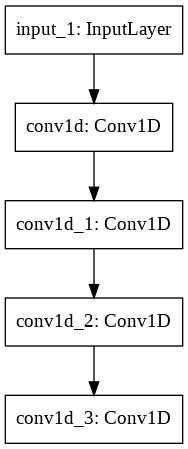

In [44]:
from tensorflow.keras.utils import plot_model
plot_model(model_conv1d, to_file='model.png')

In [45]:
history = model_conv1d.fit(GENSIMtrainX, GENSIMtrainY, epochs=5, batch_size=200, validation_data=(GENSIMtestX, GENSIMtestY)) # Обучаем модель на сверточной сети

Epoch 1/5
68/68 [==============================] - 2s 34ms/step - loss: 1.4058 - dice_coef: 0.1874 - val_loss: 1.7929 - val_dice_coef: 0.2038
Epoch 2/5
68/68 [==============================] - 2s 31ms/step - loss: 1.3993 - dice_coef: 0.1880 - val_loss: 1.7832 - val_dice_coef: 0.2053
Epoch 3/5
68/68 [==============================] - 2s 31ms/step - loss: 1.3929 - dice_coef: 0.1888 - val_loss: 1.7736 - val_dice_coef: 0.2068
Epoch 4/5
68/68 [==============================] - 2s 31ms/step - loss: 1.3865 - dice_coef: 0.1900 - val_loss: 1.7639 - val_dice_coef: 0.2083
Epoch 5/5
68/68 [==============================] - 2s 30ms/step - loss: 1.3801 - dice_coef: 0.1908 - val_loss: 1.7543 - val_dice_coef: 0.2098


In [ ]:
#############################################################################################################################

###Обучаю сеть PSPnet:


#### На стандартной архитектуре:

In [46]:
model_b_PSPnet = create_PSPNet(input_shape=(xLen, embeddingSize))

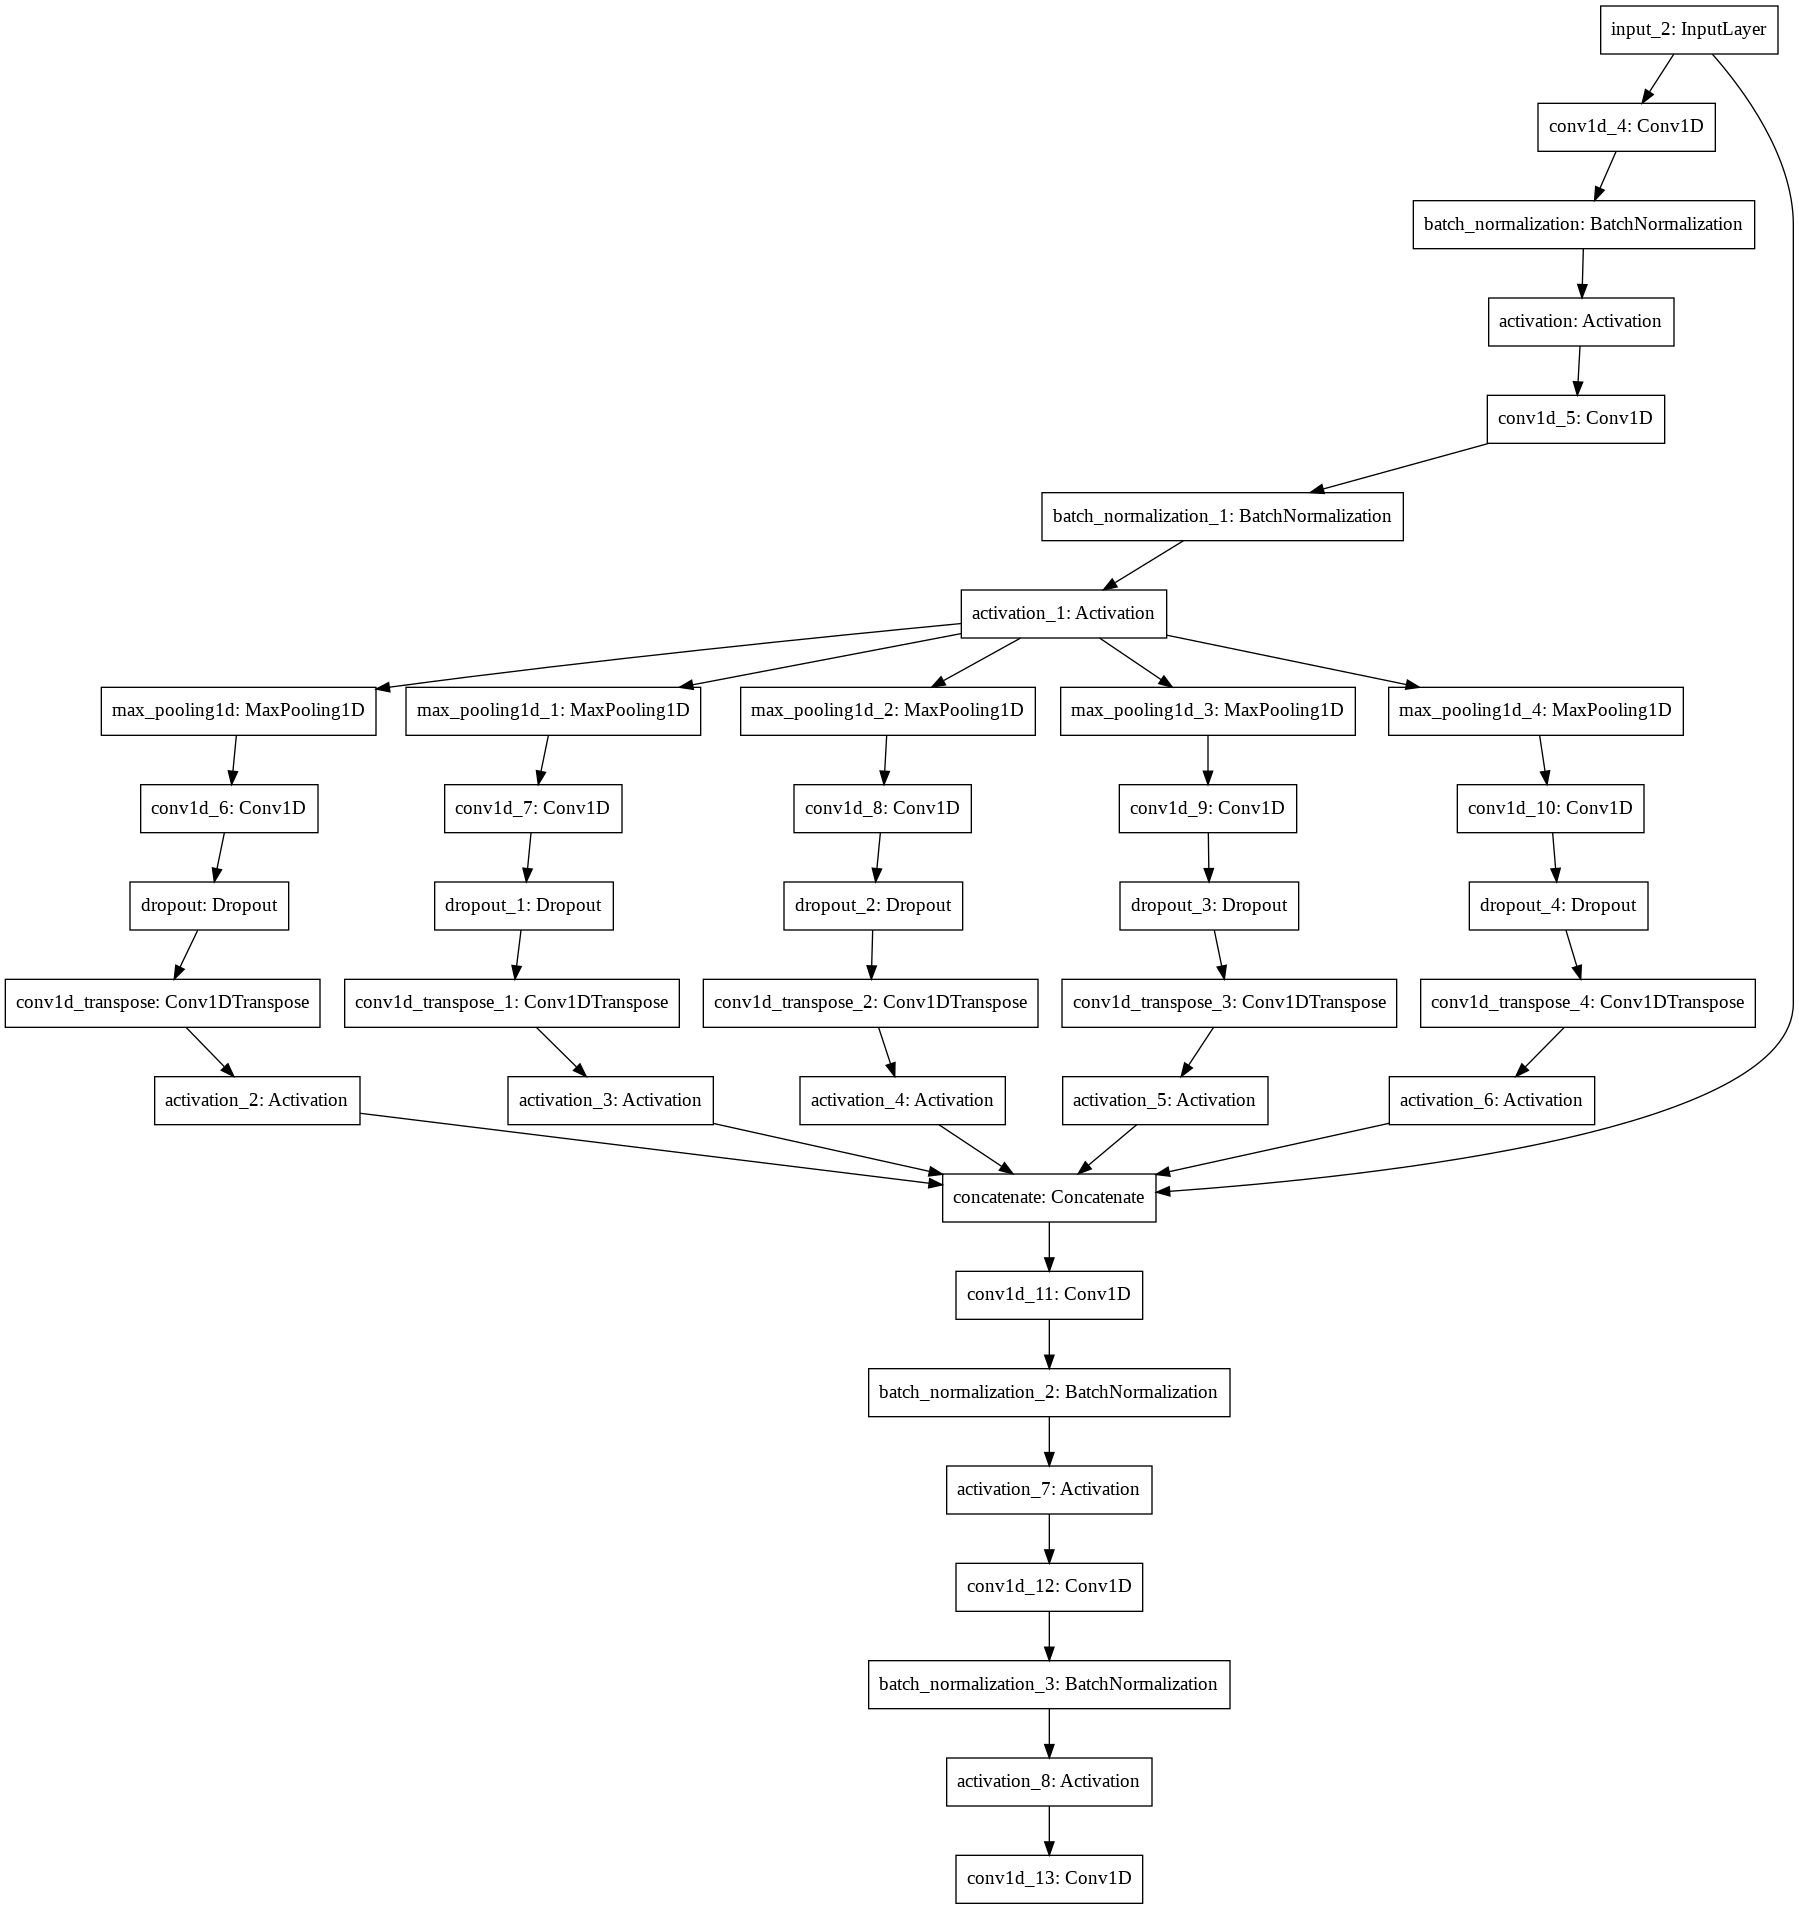

In [47]:
plot_model(model_b_PSPnet, to_file='model.png')

In [48]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
211/211 [==============================] - 6s 30ms/step - loss: 1.3572 - dice_coef: 0.1905 - val_loss: 1.6902 - val_dice_coef: 0.2270
Epoch 2/5
211/211 [==============================] - 6s 27ms/step - loss: 1.3412 - dice_coef: 0.1938 - val_loss: 1.6759 - val_dice_coef: 0.2308
Epoch 3/5
211/211 [==============================] - 6s 27ms/step - loss: 1.3248 - dice_coef: 0.1977 - val_loss: 1.6546 - val_dice_coef: 0.2356
Epoch 4/5
211/211 [==============================] - 6s 27ms/step - loss: 1.3081 - dice_coef: 0.2013 - val_loss: 1.6324 - val_dice_coef: 0.2406
Epoch 5/5
211/211 [==============================] - 6s 27ms/step - loss: 1.2915 - dice_coef: 0.2053 - val_loss: 1.6100 - val_dice_coef: 0.2458


#### PSPnet c 256 нейронами в свёрточном ядре:

In [49]:
model_b_PSPnet = create_PSPNet(conv_size = 256, input_shape=(xLen, embeddingSize))

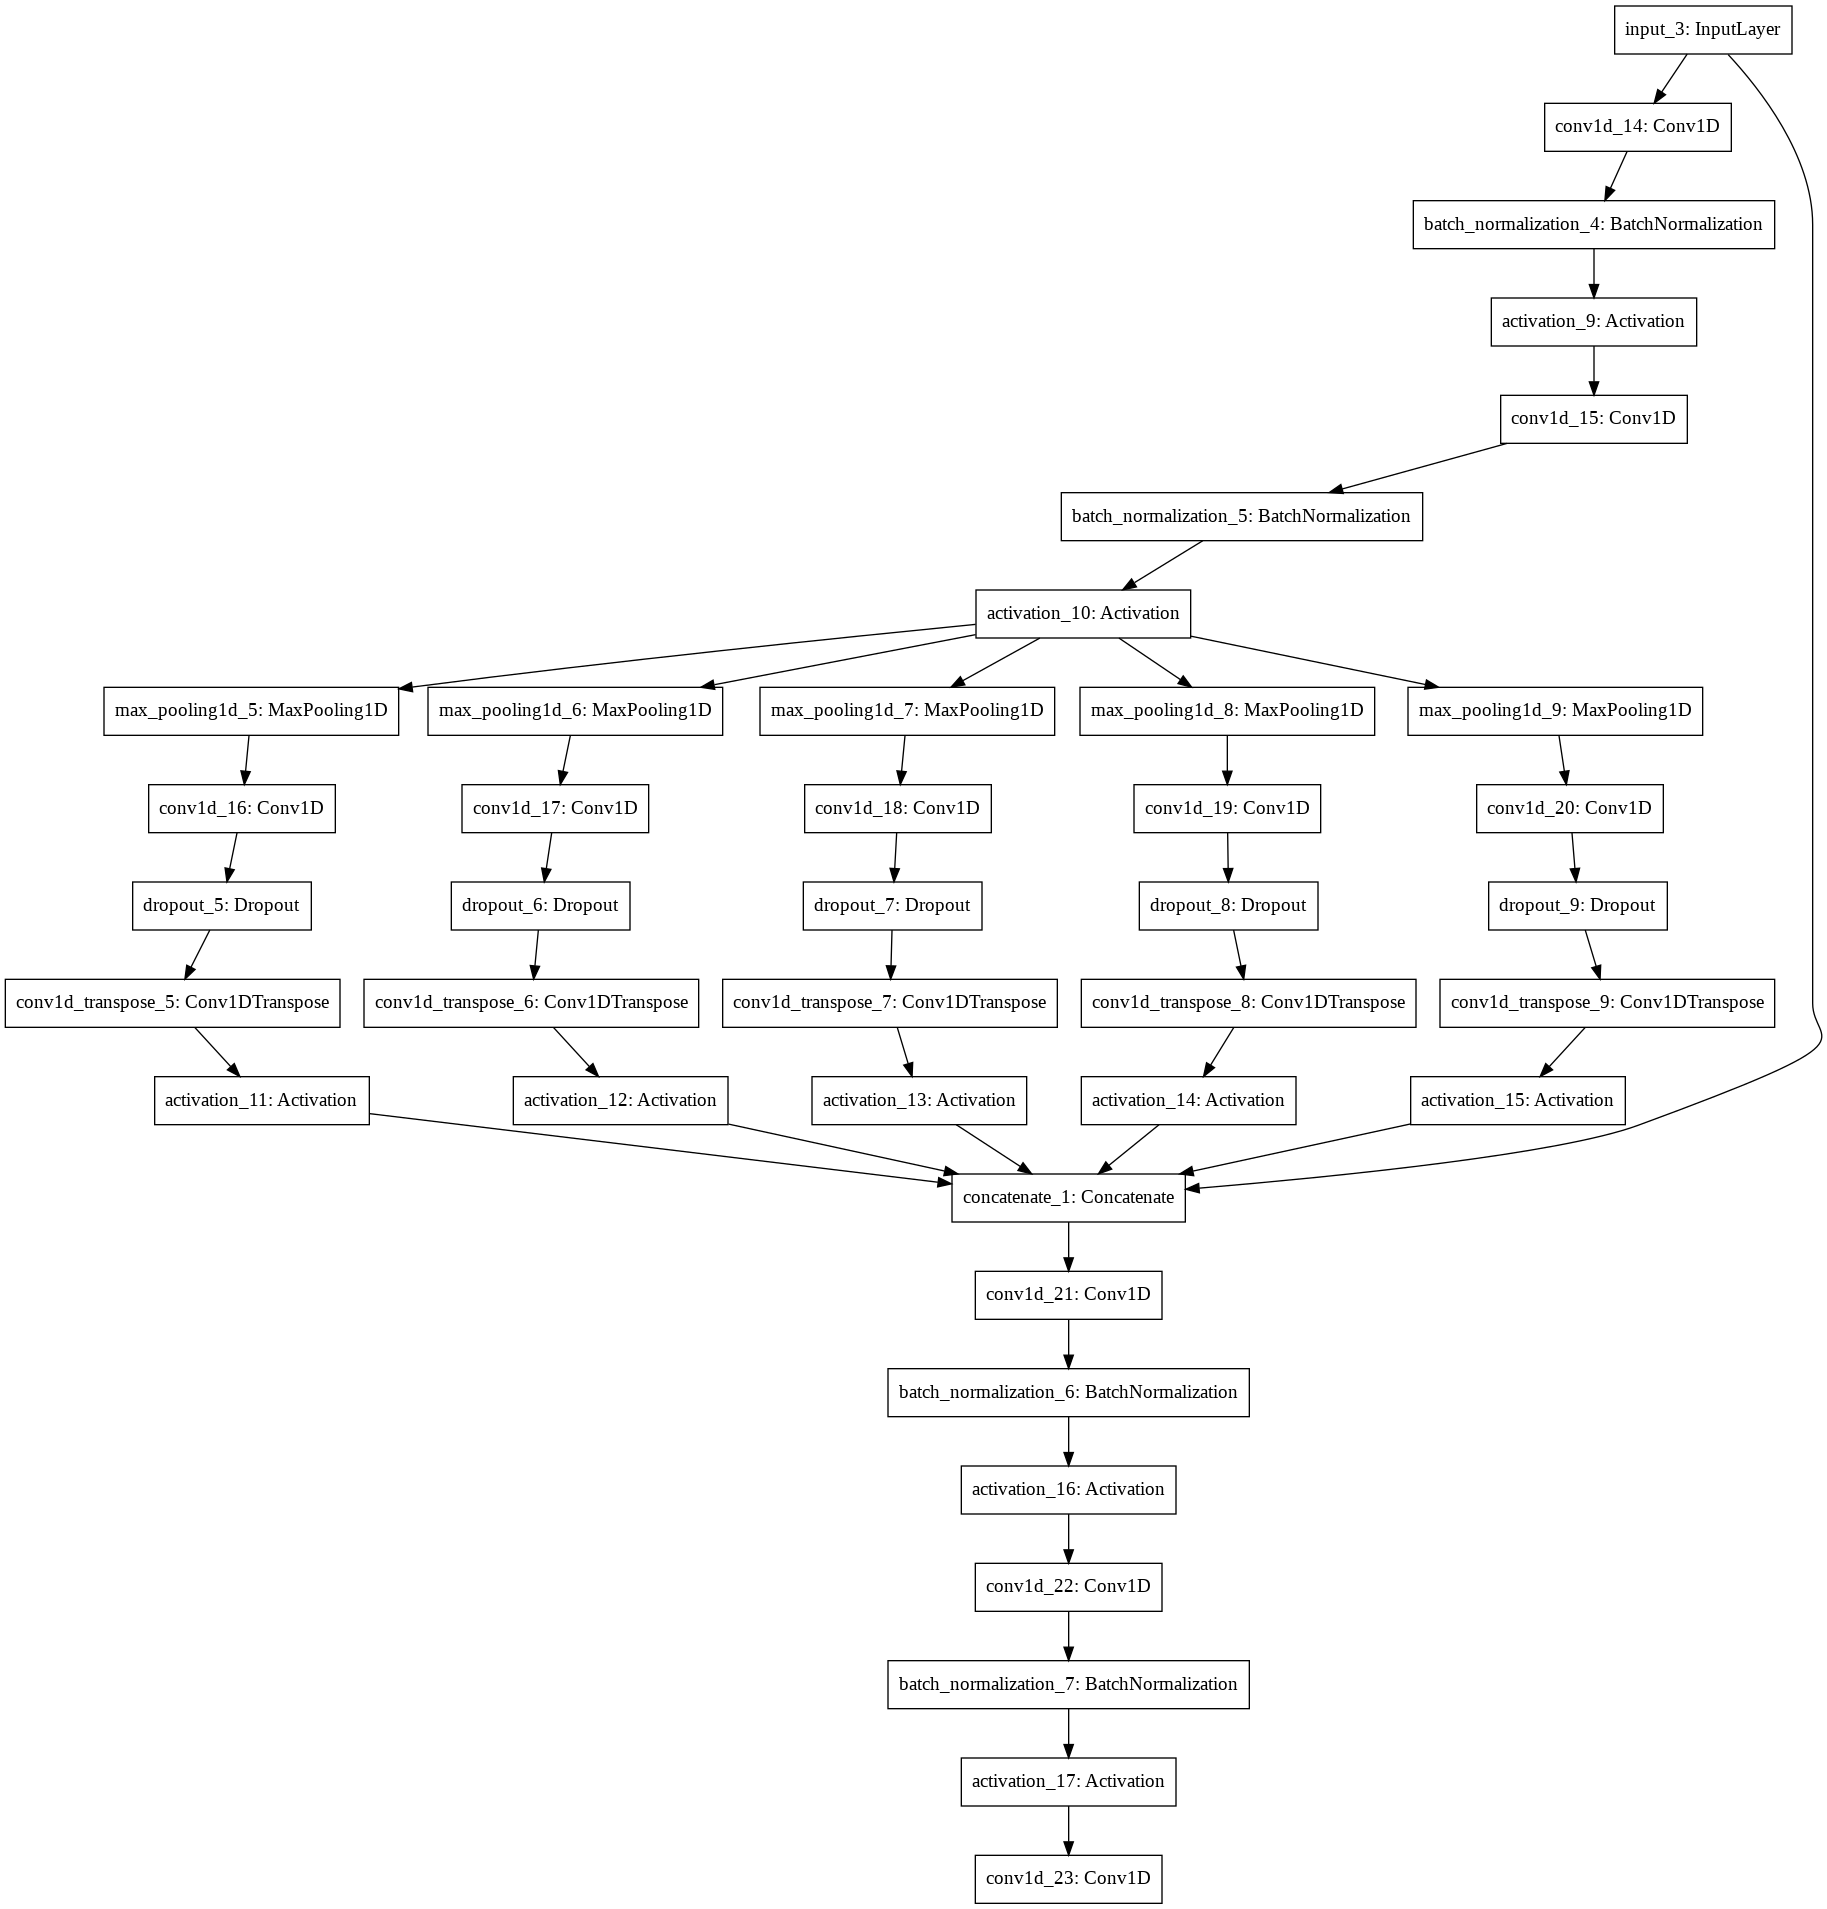

In [50]:
plot_model(model_b_PSPnet, to_file='model.png')

In [51]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64)

Epoch 1/5
211/211 [==============================] - 24s 112ms/step - loss: 1.1991 - dice_coef: 0.2383 - val_loss: 1.4333 - val_dice_coef: 0.2981
Epoch 2/5
211/211 [==============================] - 23s 111ms/step - loss: 1.1647 - dice_coef: 0.2475 - val_loss: 1.3964 - val_dice_coef: 0.3103
Epoch 3/5
211/211 [==============================] - 23s 110ms/step - loss: 1.1324 - dice_coef: 0.2573 - val_loss: 1.3566 - val_dice_coef: 0.3224
Epoch 4/5
211/211 [==============================] - 23s 109ms/step - loss: 1.1023 - dice_coef: 0.2670 - val_loss: 1.3180 - val_dice_coef: 0.3345
Epoch 5/5
211/211 [==============================] - 23s 109ms/step - loss: 1.0735 - dice_coef: 0.2771 - val_loss: 1.2805 - val_dice_coef: 0.3467


#### PSPnet c 512 нейронами в свёрточном ядре:

In [52]:
model_b_PSPnet = create_PSPNet(conv_size = 512, input_shape=(xLen, embeddingSize))
model_b_PSPnet.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_24 (Conv1D)              (None, 256, 512)     461312      input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 256, 512)     2048        conv1d_24[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 512)     0           batch_normalization_8[0][0]      
_______________________________________________________________________________________

In [53]:
history = model_b_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=25, batch_size=64)

Epoch 1/25
211/211 [==============================] - 72s 342ms/step - loss: 1.3949 - dice_coef: 0.1850 - val_loss: 1.6787 - val_dice_coef: 0.2310
Epoch 2/25
211/211 [==============================] - 70s 334ms/step - loss: 1.3084 - dice_coef: 0.2044 - val_loss: 1.5840 - val_dice_coef: 0.2555
Epoch 3/25
211/211 [==============================] - 71s 335ms/step - loss: 1.2306 - dice_coef: 0.2239 - val_loss: 1.4818 - val_dice_coef: 0.2818
Epoch 4/25
211/211 [==============================] - 71s 336ms/step - loss: 1.1591 - dice_coef: 0.2439 - val_loss: 1.3875 - val_dice_coef: 0.3079
Epoch 5/25
211/211 [==============================] - 71s 335ms/step - loss: 1.0942 - dice_coef: 0.2644 - val_loss: 1.3008 - val_dice_coef: 0.3341
Epoch 6/25
211/211 [==============================] - 71s 335ms/step - loss: 1.0368 - dice_coef: 0.2839 - val_loss: 1.2234 - val_dice_coef: 0.3597
Epoch 7/25
211/211 [==============================] - 71s 334ms/step - loss: 0.9879 - dice_coef: 0.3026 - val_loss: 1.

###Обучаю сеть UNET:


In [54]:
model_b_UNET = create_unet(input_shape=(xLen, embeddingSize))
model_b_UNET.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 300)]   0                                            
__________________________________________________________________________________________________
conv1d_34 (Conv1D)              (None, 256, 64)      57664       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 256, 64)      256         conv1d_34[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 256, 64)      0           batch_normalization_12[0][0]     
______________________________________________________________________________________

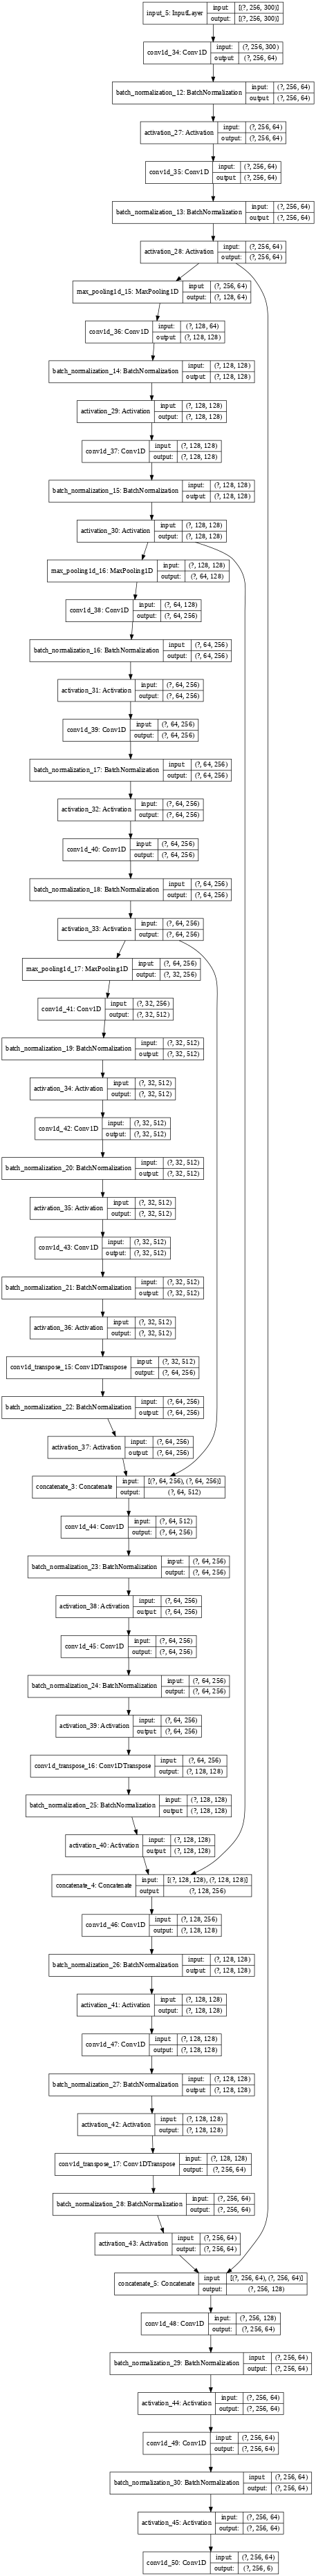

In [56]:
utils.plot_model(model_b_UNET, dpi=50, show_shapes=True)

In [58]:
history = model_b_UNET.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=10, batch_size=64) # Feed the images divided among 2 classes to the model

Epoch 1/10
211/211 [==============================] - 12s 55ms/step - loss: 0.2198 - dice_coef: 0.7410 - val_loss: 1.3218 - val_dice_coef: 0.6409
Epoch 2/10
211/211 [==============================] - 12s 55ms/step - loss: 0.2233 - dice_coef: 0.7376 - val_loss: 1.4266 - val_dice_coef: 0.6512
Epoch 3/10
211/211 [==============================] - 12s 56ms/step - loss: 0.2017 - dice_coef: 0.7612 - val_loss: 1.5951 - val_dice_coef: 0.6674
Epoch 4/10
211/211 [==============================] - 12s 56ms/step - loss: 0.2155 - dice_coef: 0.7513 - val_loss: 2.0359 - val_dice_coef: 0.6028
Epoch 5/10
211/211 [==============================] - 12s 55ms/step - loss: 0.2041 - dice_coef: 0.7608 - val_loss: 1.0812 - val_dice_coef: 0.6507
Epoch 6/10
211/211 [==============================] - 12s 55ms/step - loss: 0.2012 - dice_coef: 0.7648 - val_loss: 1.7374 - val_dice_coef: 0.6277
Epoch 7/10
211/211 [==============================] - 12s 55ms/step - loss: 0.2179 - dice_coef: 0.7462 - val_loss: 1.3668 - 

###Проверяю работу сети, опеделяю точность:


In [64]:
def recognizeSet(XX, YY, model, tags, length, value):
    correct_list = np.array([0] * 6)                  # массив правильных ответов в нули (сколько раз правильно определили класс)
    incorrect_list =  np.array([0] * 6)               # массив неправильных ответов в нули  (сколько раз неправильно определили класс)
    XX_array = XX
    YY_array = YY
    pred = model.predict(XX_array)
    pred[pred < value] = 0
    pred[pred > value] = 1

    for element in range(YY_array.shape[0]):          # по всем примерам в батче
      for word in range(YY_array.shape[1]):           # по каждому слову
        for category in range(YY_array.shape[2]):     # по каждой категории в слове
          if pred[element][word][category] == YY_array[element][word][category]:  # если предсказанное значение совпадает с истинным:
            correct_list[category] += 1               # отмечаем правильно предсказанный класс объекта
          else:                                       # если предсказанное значение НЕ совпадает с истенным:
            incorrect_list[category] += 1             # отмечаем, что не правильно предсказан класс объекта
        
    # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
    for i in range(6):
        print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
        total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
    print("Средняя точность {}%".format(total))

In [61]:
print('Размер xTrain:', GENSIMtestX.shape)
print('Размер yTrain:', GENSIMtestY.shape)

Размер xTrain: (299, 256, 300)
Размер yTrain: (299, 256, 6)


In [62]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
# s1 Условия
# s2 Запреты
# s3 Стоимость (услуг и прочее)
# s4 Условия (относительно дат - дедлайны)
# s5 Штрафы
# s6 Адреса и местоположения

In [65]:
print("Проверка Conv1d сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_conv1d, tags, xLen, 0.5) 

Проверка Conv1d сети:
Сеть распознала категорию  'S1' с точностью в 41.9%
Сеть распознала категорию  'S2' с точностью в 70.77%
Сеть распознала категорию  'S3' с точностью в 17.76%
Сеть распознала категорию  'S4' с точностью в 86.77%
Сеть распознала категорию  'S5' с точностью в 74.17%
Сеть распознала категорию  'S6' с точностью в 81.87%
Средняя точность 62.21%


In [66]:
print("Проверка PSPnet сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_PSPnet, tags, xLen, 0.5) 

Проверка PSPnet сети:
Сеть распознала категорию  'S1' с точностью в 61.42%
Сеть распознала категорию  'S2' с точностью в 99.21%
Сеть распознала категорию  'S3' с точностью в 83.38%
Сеть распознала категорию  'S4' с точностью в 91.57%
Сеть распознала категорию  'S5' с точностью в 92.66%
Сеть распознала категорию  'S6' с точностью в 99.35%
Средняя точность 87.93%


In [67]:
print("Проверка UNET сети:")
recognizeSet(GENSIMtestX, GENSIMtestY, model_b_UNET, tags, xLen, 0.1) # Проверяем UNET архитектуру

Проверка UNET сети:
Сеть распознала категорию  'S1' с точностью в 66.62%
Сеть распознала категорию  'S2' с точностью в 97.78%
Сеть распознала категорию  'S3' с точностью в 77.75%
Сеть распознала категорию  'S4' с точностью в 89.13%
Сеть распознала категорию  'S5' с точностью в 84.72%
Сеть распознала категорию  'S6' с точностью в 98.95%
Средняя точность 85.82%


In [ ]:
# ВЫВОД:  самым перспетивными типами сетей для данной задачи по сегментации длговоров
#         являются сети PSP & UNET